<a href="https://colab.research.google.com/github/h0806449f/PyTorch/blob/main/DB_04_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **=== 0. Pytorch Domain Libraries ===**
1. Info
    https://pytorch.org/blog/new-library-updates-in-pytorch-2.0/
2. To do list
    1. torch vision : https://pytorch.org/vision/stable/
    2. torch audio : https://pytorch.org/audio/stable/
    3. torch rec : https://pytorch.org/torchrec/

In [1]:
import torch
from torch import nn

torch.__version__

'2.0.1+cu118'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# **=== 1. Get data ===**
1. 原資料集 : Food 101
    1. 101 classes
    2. 1000 images
2. 截取部分資料及內容 :
    1. https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb
    2. 3 classes
    3. 10% - 20% images of food 101

In [3]:
import requests
import zipfile
from pathlib import Path

# 設置資料路徑
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# 判斷資料夾存在與否
if image_path.is_dir():
    print(f"{image_path} directory already exist, skipping download")
else:
    print(f"{image_path} doesn't exist, creating")
    image_path.mkdir(parents=True, exist_ok=True)

# 下載壓縮檔
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(request.content)

# 解壓縮
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping the file")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi doesn't exist, creating
Unzipping the file


# 1.1 檢視資料結構
1. 注意資料夾與資料結構
2. train
    3 floders of different type images
3. test
    3 floders of different type images

In [4]:
# Walk function
import os

def walk_through_dir(dir_path):
    """Walk through dir_path, returning the content in it"""

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} dirs and {len(filenames)} images in {dirpath}.")

In [5]:
# 資料結構
walk_through_dir(image_path)

There are 2 dirs and 0 images in data/pizza_steak_sushi.
There are 3 dirs and 0 images in data/pizza_steak_sushi/train.
There are 0 dirs and 78 images in data/pizza_steak_sushi/train/pizza.
There are 0 dirs and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 dirs and 75 images in data/pizza_steak_sushi/train/steak.
There are 3 dirs and 0 images in data/pizza_steak_sushi/test.
There are 0 dirs and 25 images in data/pizza_steak_sushi/test/pizza.
There are 0 dirs and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 dirs and 19 images in data/pizza_steak_sushi/test/steak.


In [6]:
# 圖片位置
print(image_path)

data/pizza_steak_sushi


In [7]:
# Setup training and testing paths

train_dir = image_path / "train"
test_dir = image_path / "test"

print(f"train 路徑: {train_dir}")
print(f"test 路徑: {test_dir}")

train 路徑: data/pizza_steak_sushi/train
test 路徑: data/pizza_steak_sushi/test


# 1.2 檢視圖片

1. Get all of the image "path"
2. Pick random image path  (`random.choice()`)
3. Get image class name  (`pathlib.Path.parent.stem`)
4. Open image  (`PIL`)
5. Show image and print info

In [8]:
# 1. Get all image path
import random
from PIL import Image

# 設置 random seed
random.seed(42)

# "path" list
# image_path -> content/data/pizza_steak_sushi

image_path_list = list(image_path.glob("*/*/*.jpg"))  # 注意層數

In [9]:
# 2. Random pick
random_image_path = random.choice(image_path_list)
random_image_path

PosixPath('data/pizza_steak_sushi/train/pizza/2291093.jpg')

In [10]:
# 3. Get image class name
image_class = random_image_path.parent.stem
image_class

'pizza'

In [11]:
# 額外 : 如要選取路經中的檔案名稱
file_name = random_image_path.name
file_name

'2291093.jpg'

In [12]:
# 4. Show image
img = Image.open(random_image_path)

圖片路徑: data/pizza_steak_sushi/train/pizza/2291093.jpg
圖片類別: pizza | 名稱: 2291093.jpg
高: 512 | 寬: 512


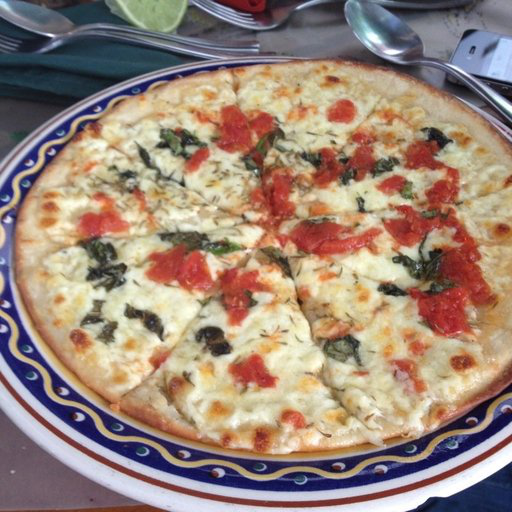

In [13]:
# 5. Show image and image_info

print(f"圖片路徑: {random_image_path}")
print(f"圖片類別: {image_class} | 名稱: {file_name}")
print(f"高: {img.height} | 寬: {img.width}")
img

# 1.2.1 檢視圖片 -> Matplotlib

(-0.5, 511.5, 511.5, -0.5)

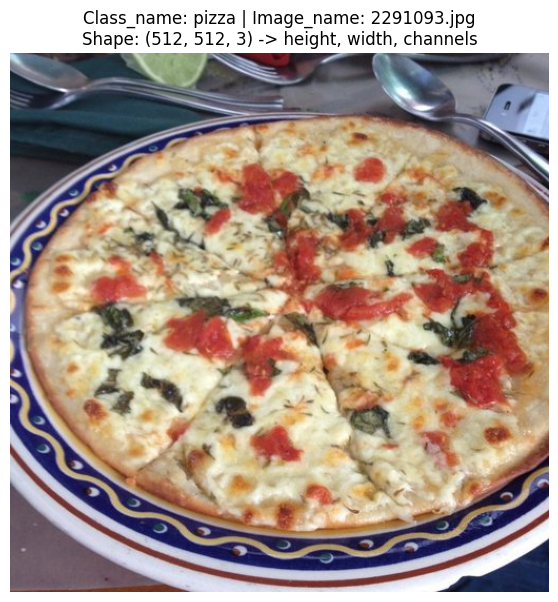

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image to array
img_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(7, 7))
plt.imshow(img_array)
plt.title(f"Class_name: {image_class} | Image_name: {file_name}\nShape: {img_array.shape} -> height, width, channels")
plt.axis("off")

# **=== 2. 資料預處理 & 資料增強===**

PyTorch 需要的資料型態 **tensor**
1. 將所有圖片都轉成 tensor
2. `torch.utils.data.Dataset`
    自定義資料集
3. `torch.utils.data.DataLoader`
    可迭代, 將資料及內容以批次的方式提供出來
4. 數據增強
    https://pytorch.org/vision/master/transforms.html
    1. `transforms.Resize(size)`
    2. `transforms.RandomHorizontalFlip(p)`
    3. `transforms.RandomVerticalFlip(p)`
    4. `transforms.RandomRotation(degrees)`
    5. `transforms.ColorJitter(brightness, contrast, saturation, hue)`
    對圖像的亮度、對比度、飽和度和色調進行隨機調整。
    6. `transforms.RandomCrop(size)`
    隨機從圖像中裁剪出指定大小的區域。
    7. `transforms.Normalize(mean, std)`



In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# transforms -> convert PIL or numpy image to tensor

In [16]:
# Write a "transform" for image
data_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),        # resize 配合CNN 所需輸入
    transforms.RandomHorizontalFlip(p = 0.5),  # 水平翻轉 -> 資料增強
    transforms.ToTensor()                      # to tensor, 會同時將數據 "歸一化"
])

In [17]:
data_transform(img).shape

torch.Size([3, 64, 64])

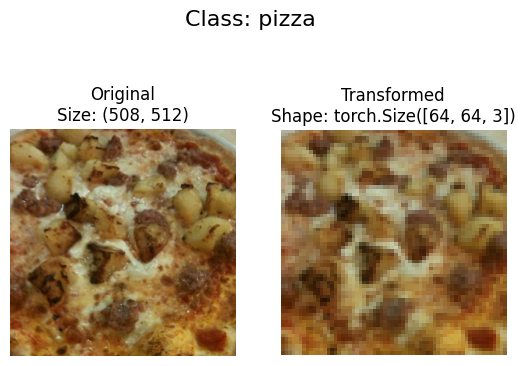

In [18]:
# 自定義一個 function 將 image_path_list 中的路徑 轉換成tensor
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    # check seed
    if seed:
        random.seed(seed)
    # 隨機選3張圖片轉換
    random_image_paths = random.sample(image_paths, k=n)

    # subplot
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)

            # 展示原圖
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis("off")

            # 展示轉換後的圖
            # 注意 : PIL vs matplotlib 將 channels 放在不同的位置 -> rearrange
            # permute
            transformed_image = data_transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            # 大標
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n=1,
                        seed=None)

# 2.1 ImageFolder

https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html
1. `torchvision.datasets.ImageFolder`
2. Dataset ImageFolder -> classes
3. 自製一個類似 `torchvision.datasets.ImageFolder` 的功能





In [19]:
# Use ImageFolder to create dataset
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,  # for data
                                  target_transform = None)     # for label/target

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform,
                                 target_transform = None)

train_dir, train_data, test_dir, test_data

(PosixPath('data/pizza_steak_sushi/train'),
 Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 PosixPath('data/pizza_steak_sushi/test'),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [20]:
# Get class names -> list (內建的屬性)
class_list = train_data.classes
class_list

['pizza', 'steak', 'sushi']

In [21]:
# Get class names -> dict (內建的屬性)
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [22]:
# 內建屬性 : samples -> 返回路徑, 路徑label
train_data.samples[0:10]

[('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1089334.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1105700.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/12301.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1285298.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/138855.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1412034.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1524655.jpg', 0)]

# 2.1.1 ImageFolder 額外操作
1. Check info
2. Visualize

In [23]:
# train_data -> 每一個資料為tuple
# [0] -> 圖片 tensor
# [1] -> label

img, label = train_data[0][0], train_data[0][1]

print(f"Image tensor:\n{img}")
print(f"\nImage shape: {img.shape} | Image label: {class_list[label]}" )
print(f"\nImage dtype: {img.dtype} | Label dtype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Before permute: torch.Size([3, 64, 64])
After permute: torch.Size([64, 64, 3])


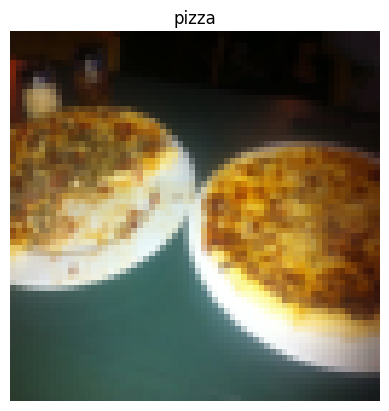

In [24]:
# Visualize
img_permute = img.permute(1, 2, 0)

# Check shapes
print(f"Before permute: {img.shape}")
print(f"After permute: {img_permute.shape}")

# Show image
plt.imshow(img_permute)
plt.title(class_list[label])
plt.gca().set_axis_off()

# **=== 3. Turn datasets to DataLoaders ===**
1. DataLoader -> iterables
2. DataLoader -> customize our batch size

In [25]:
# Trun train_data * test_data into DataLoader
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# For train
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = True)  # 訓練時避免記憶

# For test
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = NUM_WORKERS,
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f44382bb2b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f443c64c3d0>)

In [26]:
# 32 * 7 = 224  / 餘 1 -> 自己一個batch
len(train_dataloader)

8

In [27]:
# 確認 train_dataloader 作用
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} \n-> [batch_size, color_channels, height, width]")

print(f"\nLabel shape: {label.shape} \n-> [batch_size os label index]")

Image shape: torch.Size([32, 3, 64, 64]) 
-> [batch_size, color_channels, height, width]

Label shape: torch.Size([32]) 
-> [batch_size os label index]


# **=== 4. Data Augmentation ===**
https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/


In [28]:
# trivailaugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),  # 弱-強 0 - 31
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor()
])

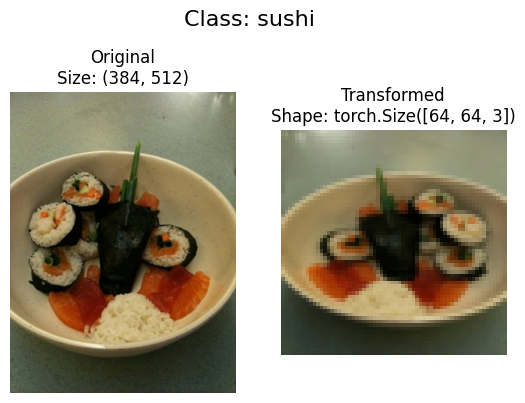

In [29]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=1,
                        seed=None)

# **=== 5. Model_0: TinyVGG without data augmentation ===**
Replicate TinyVGG architecture from the CNN Explainer
https://poloclub.github.io/cnn-explainer/

# 5.1 Creating transforms and loading data for Model_0

In [30]:
# Create simple transform
simple_transform = transforms.Compose([transforms.Resize(size = (64, 64)),
                                       transforms.ToTensor()
])

In [31]:
# 1. Load and transform data
from torchvision import datasets

# Load train data
train_data_simple = datasets.ImageFolder(root = train_dir,
                                         transform = simple_transform)

# Load test data
test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = simple_transform)

In [32]:
# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

#
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create train DataLoader
train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True,
                                     num_workers = NUM_WORKERS)

# Create test DataLoader
test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers = NUM_WORKERS)

# 5.2 Set & Create Model_0 (TinyVGG)

In [33]:
# 設置模型架構
# subclass
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()

        # Blocks and Layers
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = (3, 3),
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = (3, 3),
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2, 2))
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = (3, 3),
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = (3, 3),
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2, 2))
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units*16*16,
                      out_features = output_shape)
        )

    # Forward pass
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # 以下方法, GPU 在運算時, 記憶體消耗較少, 速度較快
        # self.classifier(self.conv_block_2(self.conv_block_1(x)))
        # return x

In [34]:
# 依照設置的架構 -> 建立模型
torch.manual_seed(42)

model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(class_list)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

# 5.3 Using single batch to try forward pass
尚未訓練 -> 為了測試 Model_0 是否能夠正常運作

In [35]:
# Create single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))

image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [36]:
# Checking shape
model_0(image_batch.to(device))

# 模型調整前
# torch.Size([32, 10, 32, 32])
# torch.Size([32, 10, 16, 16])
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2560 and 10x3)

# 原因 : hard code out classifier layer's in_features as hidden_units

# 調整
# hidden_units * 16 * 16

tensor([[0.0578, 0.0634, 0.0352],
        [0.0658, 0.0650, 0.0398],
        [0.0702, 0.0678, 0.0412],
        [0.0687, 0.0646, 0.0417],
        [0.0625, 0.0613, 0.0355],
        [0.0587, 0.0595, 0.0358],
        [0.0634, 0.0637, 0.0375],
        [0.0653, 0.0615, 0.0376],
        [0.0678, 0.0621, 0.0348],
        [0.0620, 0.0599, 0.0370],
        [0.0607, 0.0628, 0.0387],
        [0.0637, 0.0589, 0.0352],
        [0.0658, 0.0611, 0.0369],
        [0.0703, 0.0690, 0.0330],
        [0.0557, 0.0570, 0.0357],
        [0.0631, 0.0642, 0.0388],
        [0.0639, 0.0616, 0.0375],
        [0.0605, 0.0600, 0.0374],
        [0.0623, 0.0627, 0.0369],
        [0.0740, 0.0676, 0.0400],
        [0.0621, 0.0613, 0.0361],
        [0.0632, 0.0599, 0.0366],
        [0.0662, 0.0627, 0.0334],
        [0.0638, 0.0622, 0.0394],
        [0.0670, 0.0666, 0.0363],
        [0.0650, 0.0601, 0.0405],
        [0.0639, 0.0597, 0.0395],
        [0.0733, 0.0687, 0.0412],
        [0.0697, 0.0631, 0.0402],
        [0.062

# 5.4 Checking Model_0 info
尚未訓練 -> 確認模型 summary
1. `torchinfo`

In [37]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
# summary (model's name, input_size = batch's size)

summary(model_0, input_size = (32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

# 5.5 Setting function for training and testing model_0
1. `train_step()`
2. `test_step()`
3. `train()` function to combine `train_step()` & `test_step()` to train model

In [39]:
# Create train_step()

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

    # Put model in train mode
    model.train()

    # Setup "train loss" & "train accuracy" -> accumulate each batch
    train_loss, train_acc = 0, 0

    # Loop through data loader / data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model_0(X)  # output model logits

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss = train_loss + loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate the accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc = train_acc + (y_pred_class==y).sum().item() / len(y_pred)

    # Adjust metrics -> to get average loss and average accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [40]:
# Create test_step()

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

    # Put model in test mode
    model.eval()

    # Set "test loss" & "test accuracy"
    test_loss, test_acc = 0, 0

    # Inference mode
    with torch.inference_mode():
        # Loop through data loader / data batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss = test_loss + loss.item()

            # 3. Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc = test_acc + (test_pred_labels==y).sum().item() / len(test_pred_labels)


        # Adjust metrics -> to get average loss and average accuracy per batch
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)

        return test_loss, test_acc


In [41]:
from tqdm.auto import tqdm

# 1. Create train function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),  # 設置default
          epochs: int = 3):

    # 2. Create empty results dictionary
    # 用於記錄每 epoch result
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    # 3. Loop through train step and test step
    for epoch in tqdm(range(epochs)):
        # train
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)

        # test
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)

        # 4. Print out what's happening
        print(f"Epoch: {epoch}")
        print(f"Train loss: {train_loss:.3f} | Train acc: {train_acc:.3f}")
        print(f"Test loss: {test_loss:.3f} | Test acc: {test_acc:.3f}")

        # 5. Update results dict
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results dict
    return results

# 5.6 Actual train and eval model_0
1. Setting loss_fn
    確認損失函示
2. Setting optimizer
    確認優化器

In [42]:
# Set random seeds
# 僅為了教學影片的 可再現性 真實環境不需要此設定
torch.manual_seed(42)

In [43]:
# Set number of epochs
NUM_EPOCHS = 25

# Recreate TinyVGG (只是為了讓code集中, 方便複習)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set loss function
loss_fn = nn.CrossEntropyLoss()

# Set optimizer
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)  # lr 0.001 為PyTorch預設 "通常"效果較好

# Set timer
from timeit import default_timer as timer
start = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End timer
end = timer()
total_time_model_0 = end - start
print(total_time_model_0)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0
Train loss: 1.108 | Train acc: 0.258
Test loss: 1.136 | Test acc: 0.260
Epoch: 1
Train loss: 1.085 | Train acc: 0.426
Test loss: 1.162 | Test acc: 0.198
Epoch: 2
Train loss: 1.116 | Train acc: 0.293
Test loss: 1.170 | Test acc: 0.198
Epoch: 3
Train loss: 1.096 | Train acc: 0.414
Test loss: 1.139 | Test acc: 0.198
Epoch: 4
Train loss: 1.098 | Train acc: 0.293
Test loss: 1.144 | Test acc: 0.198
Epoch: 5
Train loss: 1.096 | Train acc: 0.250
Test loss: 1.148 | Test acc: 0.260
Epoch: 6
Train loss: 1.119 | Train acc: 0.332
Test loss: 1.143 | Test acc: 0.271
Epoch: 7
Train loss: 1.102 | Train acc: 0.367
Test loss: 1.108 | Test acc: 0.198
Epoch: 8
Train loss: 1.092 | Train acc: 0.359
Test loss: 1.085 | Test acc: 0.583
Epoch: 9
Train loss: 1.072 | Train acc: 0.445
Test loss: 1.055 | Test acc: 0.594
Epoch: 10
Train loss: 1.040 | Train acc: 0.379
Test loss: 1.022 | Test acc: 0.615
Epoch: 11
Train loss: 1.150 | Train acc: 0.426
Test loss: 0.986 | Test acc: 0.625
Epoch: 12
Train loss: 1.01

In [44]:
# 過擬合了

# **=== 6. Loss curve of Model_0 ===**

In [45]:
# 確認 model_0_results dict 內容
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [46]:
# 使用 model_0_results dict內的資料 製作圖表
def plot_loss_curves(results):
    train_loss = results["train_loss"]
    train_acc = results["train_acc"]

    test_loss = results["test_loss"]
    test_acc = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    # Set plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    plt.plot(epochs, test_loss, label="Test loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train accuracy")
    plt.plot(epochs, test_acc, label="Test accuracy")
    plt.title("Accuraycy")
    plt.xlabel("Epochs")
    plt.ylabel("acc")
    plt.legend()

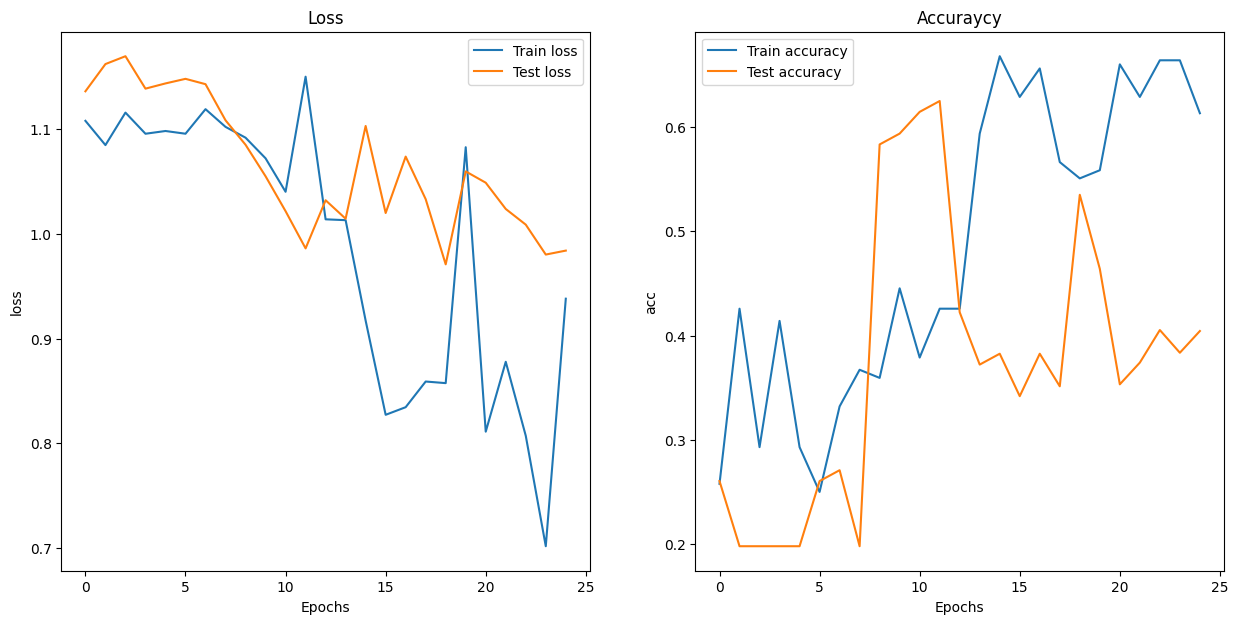

In [47]:
plot_loss_curves(model_0_results)

# **=== 7. Underfitting and Overfitting ===**
1. Under : Loss值 不夠低
2. Over : `train loss` **遠低於** `test loss`

# 7.1 For underfitting

1. Add more layers
2. Add more hidden units
3. Add more epochs
4. Learning rate (lr scheduler)
    https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
    (How to adjust learning rate)

5. !!! Use transfer learning !!!

# 7.2 For overfitting

1. More data
2. Data augmentation
3. 簡化模型
4. Drop out layer
5. Learning rate (lr scheduler)
6. Early stopping
7. !!! Use transfer learning !!!

# **=== 8. Model_1 ===**
1. `Dataset` and `DataLoader` with more data augmentation
1. Basic model structure -> `TinyVGG`
2.

# 8.1 Create transform with data augmentation

In [48]:
# 嘗試多種 資料增強方法
from torchvision import transforms

train_transform_for_model_1 = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

test_transform_for_model_1 = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

# 8.2 Create Dateset and DataLoader with data augamentation
1. Dataset
2. DataLoader

In [49]:
# Turn image folder into Datasets
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform_for_model_1
    )

test_data_augmented = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform_for_model_1
    )

train_data_augmented, test_data_augmented

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                RandomHorizontalFlip(p=0.4)
                RandomVerticalFlip(p=0.4)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [50]:
# Turn Datasets into DataLoader
import os
import torch
from torch.utils.data import DataLoader

# 參數
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# manual seed -> 僅為了再現性
torch.manual_seed(42)

# DataLoader
# train
train_dataloader_for_model_1 = DataLoader(
    dataset=train_data_augmented,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

# test
test_dataloader_for_model_1 = DataLoader(
    dataset=test_data_augmented,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS)

# 8.3 Construct and train model_1

In [51]:
# Create model_1 and send to target device
torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [52]:
# Set loss_fn and optimizer
torch.manual_seed(42)

NUM_EPOCHS = 25

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

In [53]:
# Train
from timeit import default_timer as timer
start = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_for_model_1,
                        test_dataloader=test_dataloader_for_model_1,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS)

end = timer()
total_time_model_1 = end - start
print(total_time_model_1)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.903 | Train acc: 0.617
Test loss: 1.104 | Test acc: 0.208
Epoch: 1
Train loss: 0.964 | Train acc: 0.555
Test loss: 1.104 | Test acc: 0.208
Epoch: 2
Train loss: 0.935 | Train acc: 0.625
Test loss: 1.104 | Test acc: 0.208
Epoch: 3
Train loss: 1.152 | Train acc: 0.488
Test loss: 1.104 | Test acc: 0.208
Epoch: 4
Train loss: 0.994 | Train acc: 0.582
Test loss: 1.104 | Test acc: 0.208
Epoch: 5
Train loss: 1.000 | Train acc: 0.574
Test loss: 1.104 | Test acc: 0.208
Epoch: 6
Train loss: 0.960 | Train acc: 0.641
Test loss: 1.104 | Test acc: 0.208
Epoch: 7
Train loss: 0.932 | Train acc: 0.609
Test loss: 1.104 | Test acc: 0.208
Epoch: 8
Train loss: 1.071 | Train acc: 0.477
Test loss: 1.104 | Test acc: 0.208
Epoch: 9
Train loss: 0.947 | Train acc: 0.609
Test loss: 1.104 | Test acc: 0.208
Epoch: 10
Train loss: 0.959 | Train acc: 0.590
Test loss: 1.104 | Test acc: 0.208
Epoch: 11
Train loss: 1.012 | Train acc: 0.562
Test loss: 1.104 | Test acc: 0.208
Epoch: 12
Train loss: 1.38

# 8.4 Loss curve of model_1

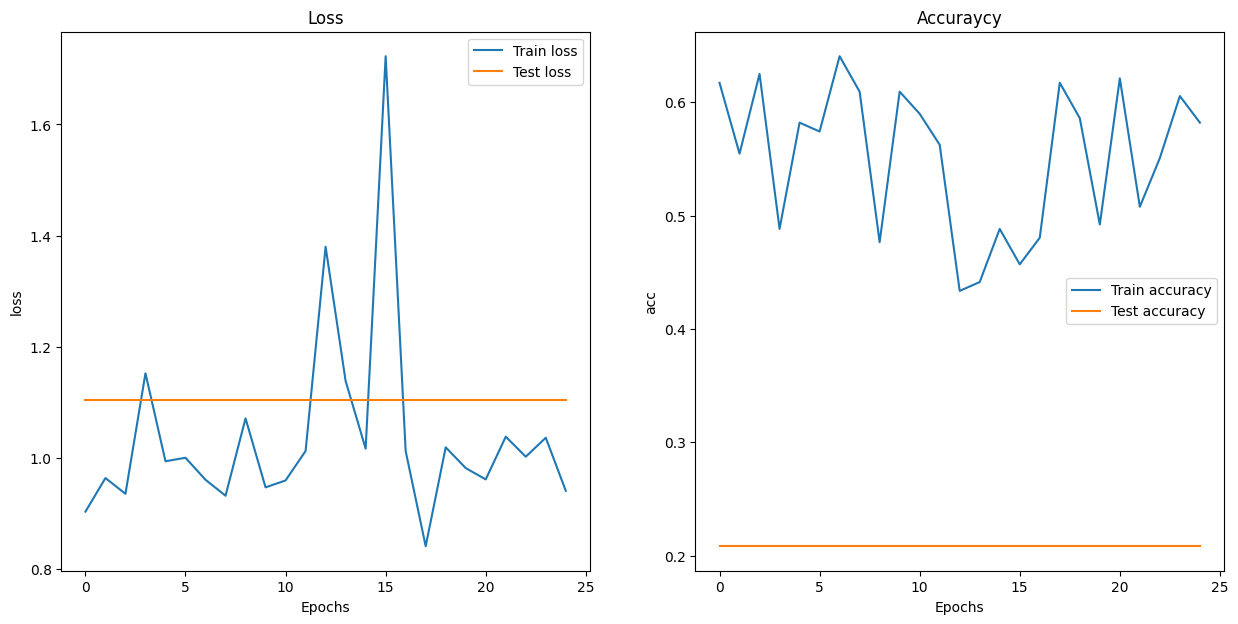

In [54]:
plot_loss_curves(model_1_results)

# **=== 9. Compare model_0 and model_1 ===**
1. Hard coding
2. PyTorch + Tensorboard:
    https://pytorch.org/docs/stable/tensorboard.html
3. Weight & Bias:
    https://wandb.ai/site/experiment-tracking

In [55]:
# Dataframe
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

model_1_df

,train_loss,train_acc,test_loss,test_acc
0,0.903052,0.617188,1.103727,0.208333
1,0.963565,0.554688,1.103727,0.208333
2,0.935240,0.625000,1.103727,0.208333
3,1.152165,0.488281,1.103727,0.208333
4,0.993834,0.582031,1.103727,0.208333
5,1.000067,0.574219,1.103727,0.208333
6,0.960442,0.640625,1.103727,0.208333
7,0.931783,0.609375,1.103727,0.208333
8,1.070991,0.476562,1.103727,0.208333
9,0.946810,0.609375,1.103727,0.208333


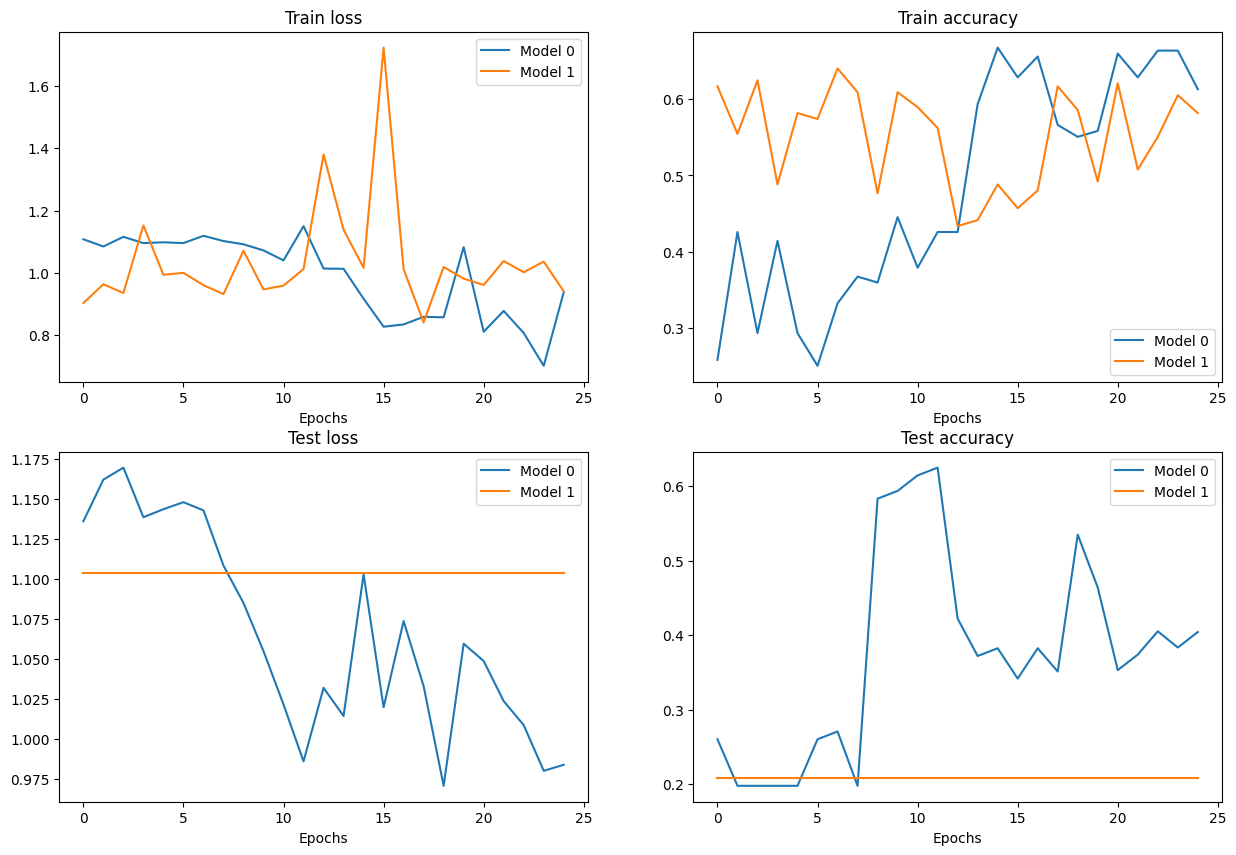

In [56]:
# Plot
plt.figure(figsize=(15, 10))

epochs = range(len(model_0_df))

# Train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

# Train accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train accuracy")
plt.xlabel("Epochs")
plt.legend()

# Test loss
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

# Test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test accuracy")
plt.xlabel("Epochs")
plt.legend()

In [57]:
summary(model_0, input_size = (32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

In [58]:
summary(model_1, input_size = (32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

# **=== 10. Make prediction ===**

In [59]:
# Download custom image
import requests

# Setup custom image path
image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not image_path.is_file():
    with open(image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {image_path}...")
        f.write(request.content)
else:
    print(f"{image_path} already exists, skipping download.")

In [60]:
# Load image with PyTorch (https://pytorch.org/vision/stable/io.html)
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(image_path))

# Image info
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

In [61]:
# datatype : uint8 -> float32
# if: uint8 to model_1 -> RuntimeError: "Input type"

custom_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

In [62]:
# Normalize
custom_image = custom_image / 255

In [63]:
# Create transform -> resize the image
from torchvision import transforms

custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

custom_image = custom_image_transform(custom_image)

# Check shape
print(custom_image.shape)

torch.Size([3, 64, 64])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [64]:
# Add batch size
custom_image = custom_image.unsqueeze(0)

# Check shape
print(custom_image.shape)

torch.Size([1, 3, 64, 64])


In [65]:
# Predict
model_1.eval()

with torch.inference_mode():
    custome_image_pred = model_1(custom_image.to(device))

In [66]:
# Convert: logits -> probability -> label
custome_image_probability = torch.softmax(custome_image_pred, dim=1)

custome_image_probability

tensor([[0.3359, 0.3368, 0.3273]])

In [67]:
#
custome_image_label = torch.argmax(custome_image_probability, dim=1).cpu()

custome_image_label

tensor([1])

In [68]:
#
class_list[custome_image_label]

'steak'

# **=== 11. Function of makeing prediction ===**

In [69]:
from typing import List

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_name: List[str] = None,
                        transform=None,
                        device=device):
    # Load in image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # Normalization : 0-255 -> 0-1
    target_image = target_image / 225

    # Transform if necessary
    if transform:
        target_image = transform(target_image)

    # Set model to device
    model.to(device)

    # Predict
    model.eval()
    with torch.inference_mode():

        # Add extra dimension (Add batch)
        target_image = target_image.unsqueeze(0)

        # Make prediction -> logits
        logits = model(target_image.to(device))

        # logits -> probs
        probs = torch.softmax(logits, dim=1)

        # probs -> label
        label = torch.argmax(probs, dim=1)

    # Plot the image
    # squeeze -> remove batch dimension
    # permute
    plt.imshow(target_image.squeeze().permute(1, 2, 0))

    if class_list:
        title = f"Pred: {class_list[label.cpu()]} | Probs: {probs.max().cpu()}"
    else:
        title = f"Pred: {label} | Probs: {probs.max().cpu()}"

    plt.title(title)
    plt.axis("off")

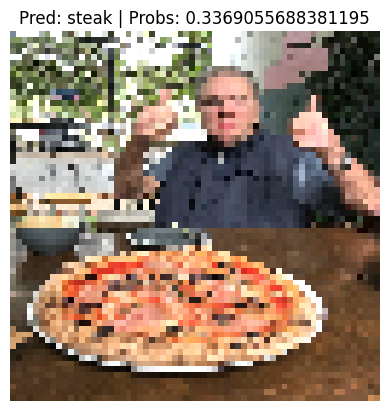

In [70]:
pred_and_plot_image(model=model_1,
                    image_path=image_path,
                    class_name=class_list,
                    transform=custom_image_transform,
                    device=device)

In [71]:
# # future warning 解決
# custom_image_transform = transforms.Compose([
#     transforms.Resize(size=(64, 64), antialias=True)
# ])